## Importing Libraries

In [17]:
import numpy as np 
import pandas as pd
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Conv2D, MaxPool2D, AveragePooling2D, BatchNormalization
from functools import partial
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import timm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from torchvision import transforms

## Load the Dataset

In [3]:
# Load the CSV file
csv_path = '..//Dataset/cards.csv'
df = pd.read_csv(csv_path)

# Inspect the CSV file
print(df.head())

   class index                   filepaths        labels card type data set
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train


In [4]:
train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

## Exploratory Data Analysis

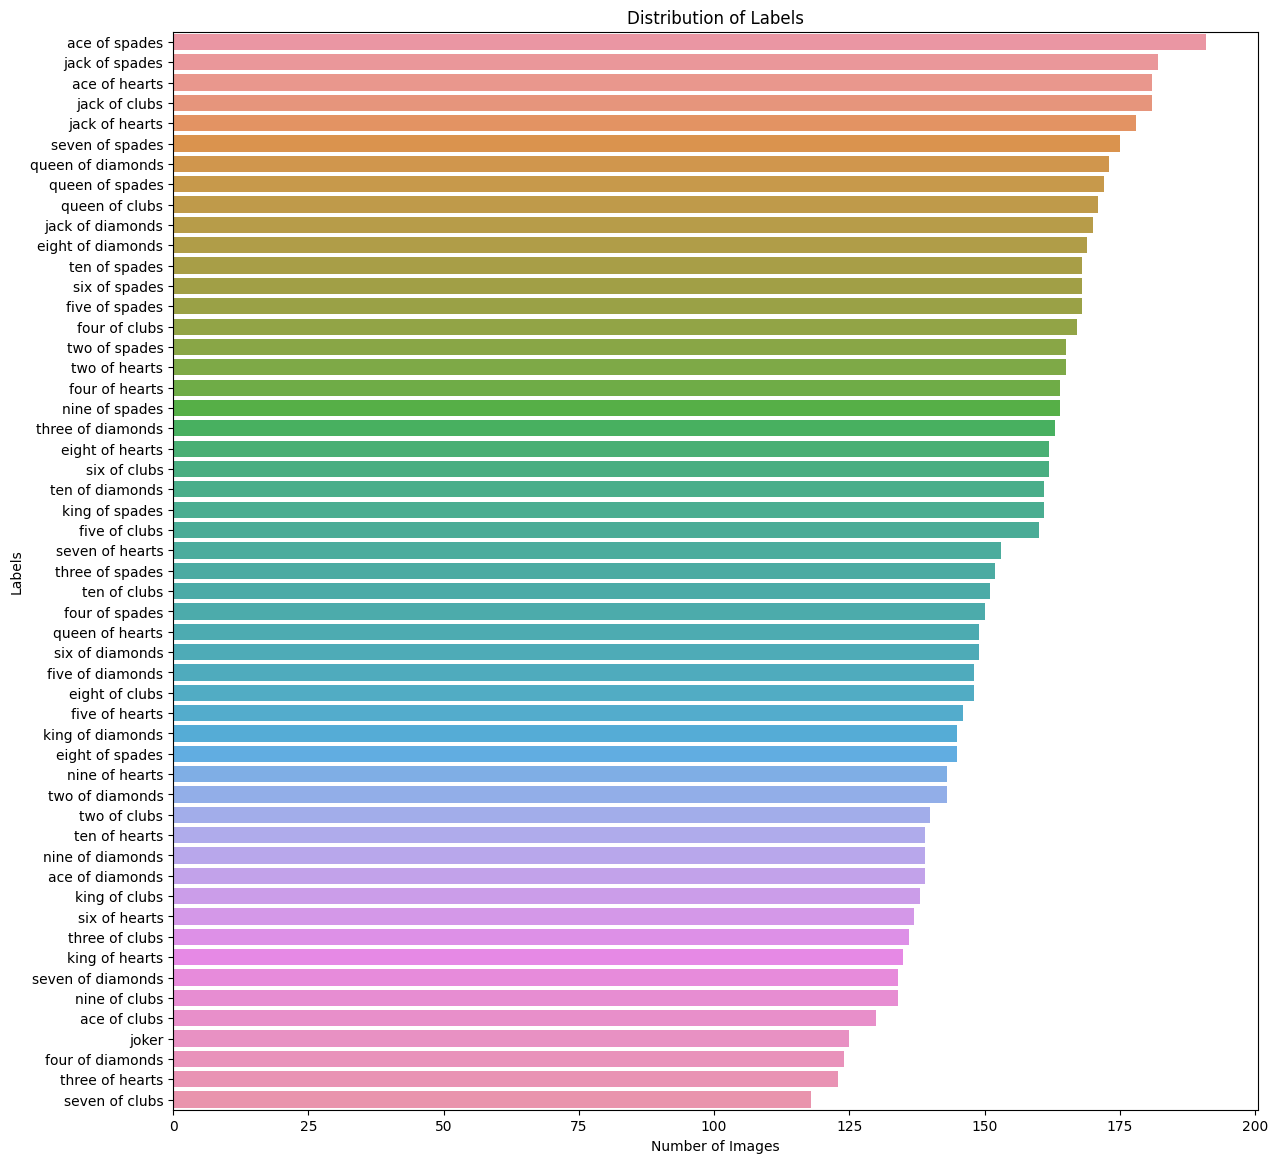

In [4]:
# Plot label distribution
plt.figure(figsize=(14, 14))
sns.countplot(y='labels', data=df, order=df['labels'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Number of Images')
plt.ylabel('Labels')
plt.savefig('../Images/Distribution of Labels.png')
plt.show()

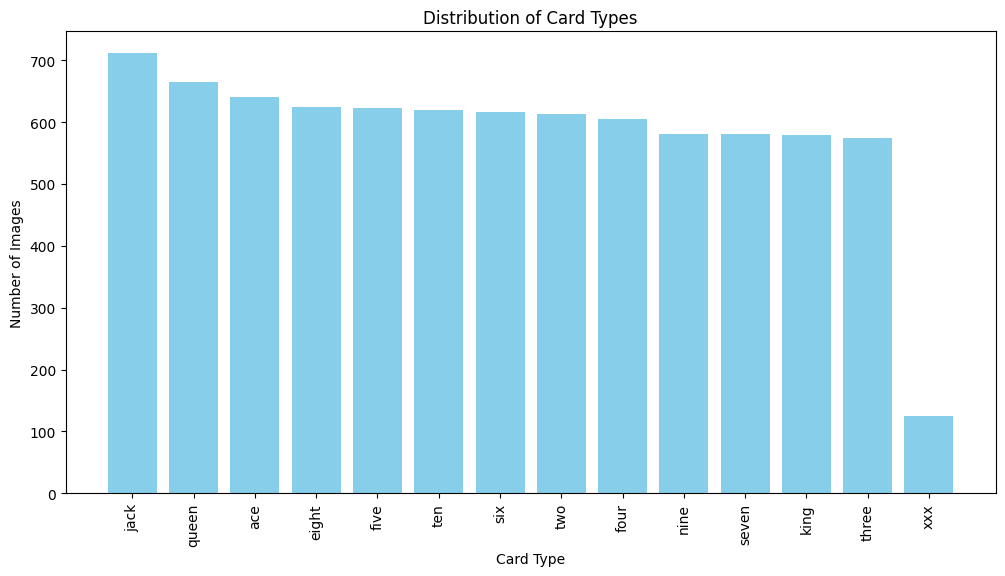

In [5]:
# Plot card type distribution
card_type_counts = df['card type'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(card_type_counts.index, card_type_counts.values, color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Card Type')
plt.ylabel('Number of Images')
plt.title('Distribution of Card Types')
plt.savefig('../Images/Distribution of Card Types.png')
plt.show()

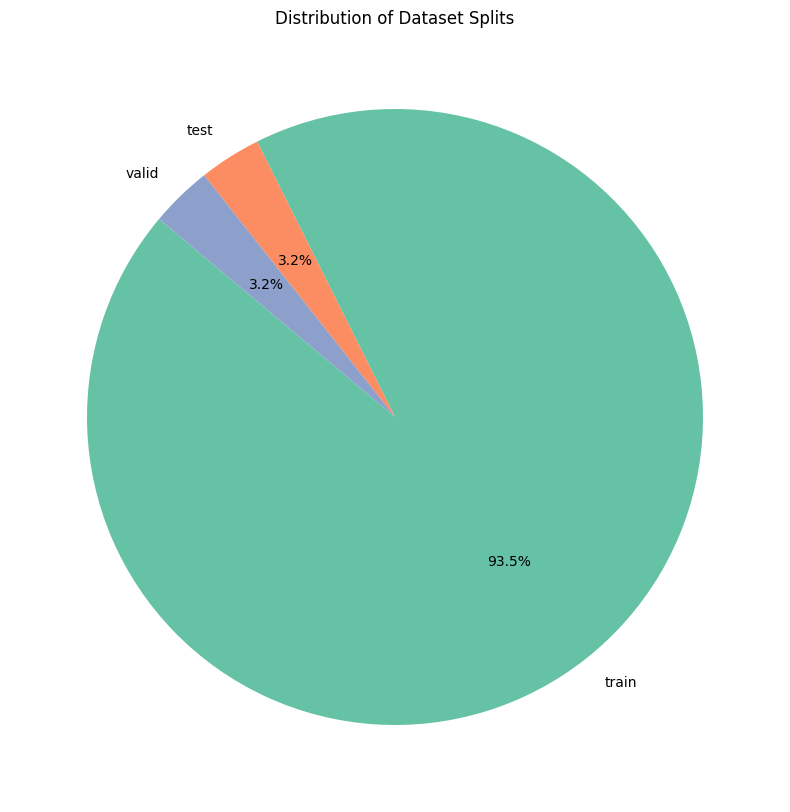

In [6]:
# Plot dataset split distribution
data_set_counts = df['data set'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(data_set_counts, labels=data_set_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Distribution of Dataset Splits')
plt.savefig('../Images/Distribution of Dataset Splits.png')
plt.show()

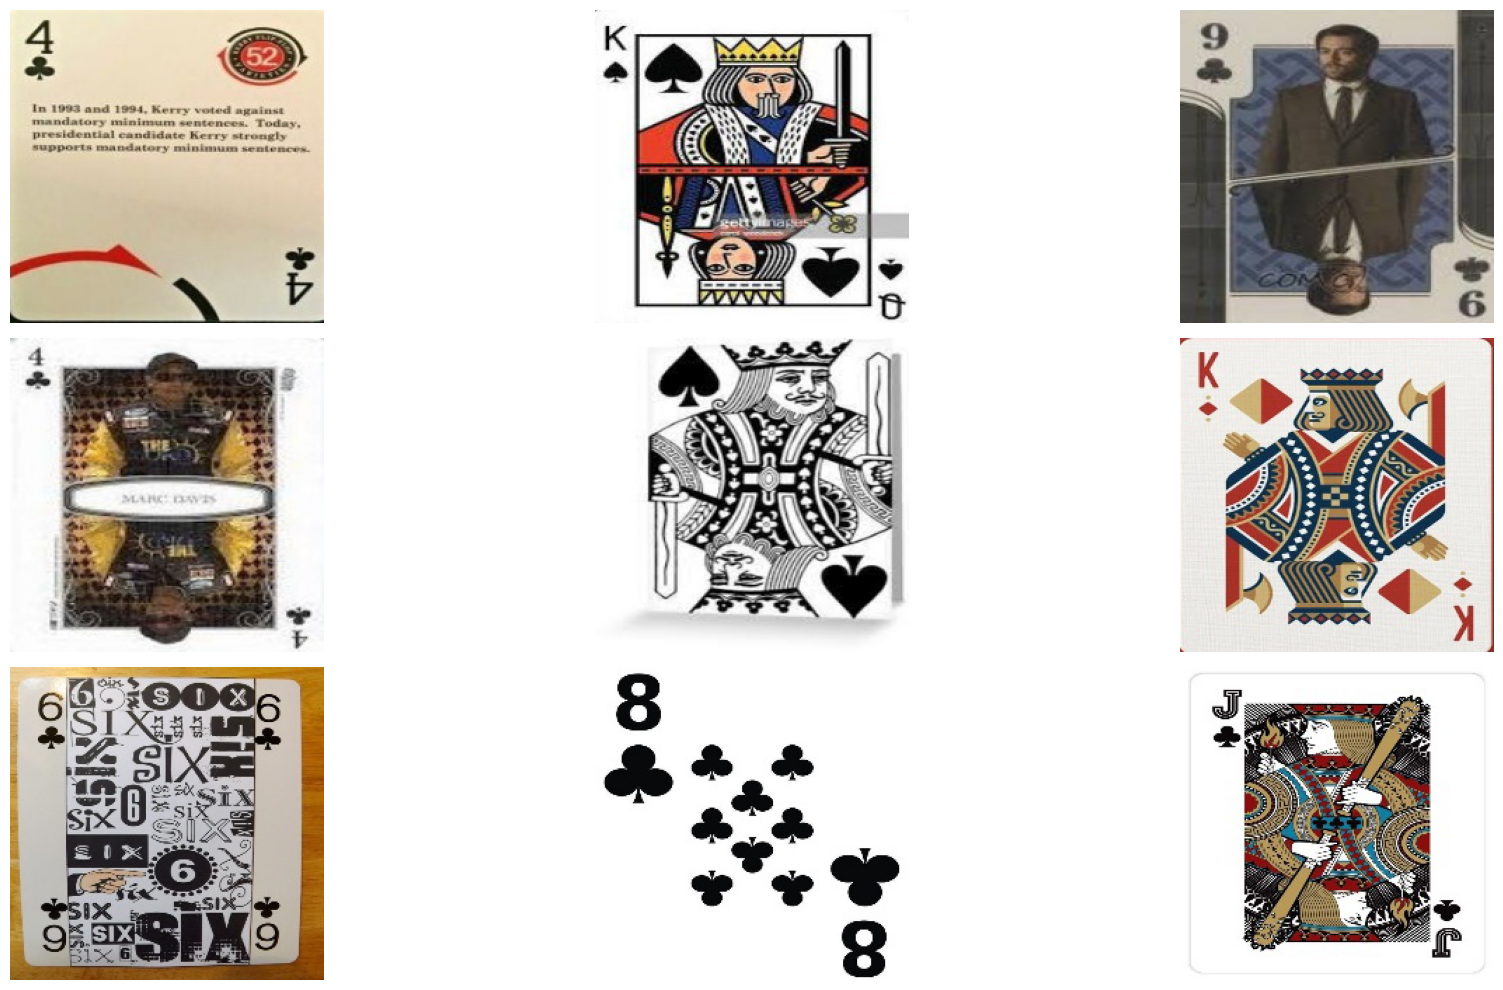

In [7]:
image_dir='../Dataset'
def plot_random_images(df, num_images=9):
    plt.figure(figsize=(20, 10))
    sample_images = df.sample(num_images)['filepaths'].values
    
    for i, img_path in enumerate(sample_images):
        img = Image.open(os.path.join(image_dir, img_path))
        plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('../Images/Dataset Visualization.png')
    plt.show()

plot_random_images(df)

## Data Spliting

In [5]:
image_dir='../Dataset'
def ImageProcessor(df):
    images = []
    labels = []

    label_encoder = LabelEncoder()
    label_encoder.fit(df['labels'].unique())
    for index, row in df.iterrows():
        # Construct the full image path
        img_path = os.path.join(image_dir, row['filepaths'])
        # Load the image
        img = Image.open(img_path)
        img = img.resize((128, 128))  # Resize images to a uniform size 
        img_array = np.array(img)

        # Append image and label to lists
        images.append(img_array)
        labels.append(row['labels'])
    X = np.array(images)
    y = np.array(labels)
    y = label_encoder.transform(y)
    
    # Shuffle the data
    X, y = shuffle(X, y, random_state=42)
    return X,y

In [6]:
X_train, y_train = ImageProcessor(train_df)
X_val, y_val = ImageProcessor(valid_df)
X_test, y_test = ImageProcessor(test_df)

In [10]:
print("Test size: ", X_train.shape[0])
print("Validation size: ", X_val.shape[0])
print("Train size: ", X_test.shape[0])

Test size:  7624
Validation size:  265
Train size:  265


In [11]:
print("Test distribution: ", Counter(y_train))
print("Validation distribution: ", Counter(y_val))
print("Train distribution: ", Counter(y_test))

Test distribution:  Counter({3: 181, 19: 172, 2: 171, 16: 171, 18: 168, 36: 165, 30: 163, 32: 162, 29: 161, 17: 160, 5: 159, 40: 158, 44: 158, 11: 158, 12: 157, 52: 155, 51: 155, 28: 154, 14: 154, 46: 153, 37: 152, 6: 152, 42: 151, 24: 151, 8: 150, 35: 143, 48: 142, 41: 141, 15: 140, 38: 139, 31: 139, 4: 138, 9: 138, 10: 136, 7: 135, 22: 135, 50: 133, 27: 133, 49: 130, 1: 129, 26: 129, 43: 129, 21: 128, 39: 127, 45: 126, 23: 125, 34: 124, 25: 124, 0: 120, 20: 115, 13: 114, 47: 113, 33: 108})
Validation distribution:  Counter({35: 5, 23: 5, 19: 5, 4: 5, 1: 5, 27: 5, 51: 5, 9: 5, 37: 5, 25: 5, 34: 5, 14: 5, 42: 5, 45: 5, 39: 5, 22: 5, 12: 5, 6: 5, 41: 5, 46: 5, 16: 5, 13: 5, 28: 5, 31: 5, 3: 5, 20: 5, 30: 5, 47: 5, 48: 5, 15: 5, 2: 5, 52: 5, 5: 5, 18: 5, 36: 5, 50: 5, 32: 5, 11: 5, 17: 5, 7: 5, 29: 5, 24: 5, 21: 5, 43: 5, 44: 5, 0: 5, 38: 5, 40: 5, 33: 5, 8: 5, 26: 5, 10: 5, 49: 5})
Train distribution:  Counter({35: 5, 23: 5, 19: 5, 4: 5, 1: 5, 27: 5, 51: 5, 9: 5, 37: 5, 25: 5, 34: 5, 14

## Scaling Images

In [7]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

## Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential(
  [
    # horizonal flip
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128,128,3)),
    # rotation
    layers.experimental.preprocessing.RandomRotation(0.1),
    # random zoom
    layers.experimental.preprocessing.RandomZoom(0.1),
    # random contrast
    layers.experimental.preprocessing.RandomContrast(0.5),
  ]
)

X_train_scaled = data_augmentation(X_train_scaled, training=True)

## Building CNN Model

In [14]:
# we have 53 image classes
num_classes = 53

model = Sequential([
    data_augmentation,
    # feature extraction
    # CONV_1
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    # POOL_1
    layers.MaxPooling2D(),
    # CONV_2
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # POOL_2
    layers.MaxPooling2D(),
    # CONV_3
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    # POOL_3
    layers.MaxPooling2D(),
    # DROPOUT_1
    layers.Dropout(0.2),
    
    # image classification
    # FLATTEN
    layers.Flatten(),
    # DENSE_1
    layers.Dense(128, activation='relu'),
    # DENSE_2
    layers.Dense(num_classes)
])

### Setup Callbacks

In [15]:
callbk=tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
my_callbacks = [callbk]

### Training

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=100,validation_data=(X_val_scaled, y_val),callbacks=my_callbacks)  

Epoch 1/100
239/239 [==============================] - 38s 153ms/step - loss: 3.5086 - accuracy: 0.1106 - val_loss: 2.7717 - val_accuracy: 0.2491
Epoch 2/100
239/239 [==============================] - 37s 154ms/step - loss: 2.7360 - accuracy: 0.2525 - val_loss: 2.2093 - val_accuracy: 0.3547
Epoch 3/100
239/239 [==============================] - 37s 153ms/step - loss: 2.4978 - accuracy: 0.3001 - val_loss: 1.9726 - val_accuracy: 0.4038
Epoch 4/100
239/239 [==============================] - 36s 152ms/step - loss: 2.3510 - accuracy: 0.3404 - val_loss: 1.7842 - val_accuracy: 0.4415
Epoch 5/100
239/239 [==============================] - 36s 151ms/step - loss: 2.2121 - accuracy: 0.3784 - val_loss: 1.6878 - val_accuracy: 0.4679
Epoch 6/100
239/239 [==============================] - 36s 152ms/step - loss: 2.1299 - accuracy: 0.3947 - val_loss: 1.5582 - val_accuracy: 0.5547
Epoch 7/100
239/239 [==============================] - 39s 161ms/step - loss: 2.0216 - accuracy: 0.4315 - val_loss: 1.5321 -

Epoch 57/100
239/239 [==============================] - 217s 910ms/step - loss: 0.7613 - accuracy: 0.7689 - val_loss: 1.2699 - val_accuracy: 0.7736
Epoch 58/100
239/239 [==============================] - 37s 153ms/step - loss: 0.7492 - accuracy: 0.7808 - val_loss: 1.3847 - val_accuracy: 0.7472
Epoch 59/100
239/239 [==============================] - 36s 150ms/step - loss: 0.7352 - accuracy: 0.7765 - val_loss: 1.3751 - val_accuracy: 0.7509
Epoch 60/100
239/239 [==============================] - 37s 153ms/step - loss: 0.7183 - accuracy: 0.7798 - val_loss: 1.3742 - val_accuracy: 0.7623
Epoch 61/100
239/239 [==============================] - 37s 153ms/step - loss: 0.7484 - accuracy: 0.7806 - val_loss: 1.5580 - val_accuracy: 0.7321
Epoch 62/100
239/239 [==============================] - 37s 154ms/step - loss: 0.7257 - accuracy: 0.7791 - val_loss: 1.5853 - val_accuracy: 0.7283
Epoch 63/100
239/239 [==============================] - 37s 157ms/step - loss: 0.7211 - accuracy: 0.7845 - val_loss: 

### Evaluation

In [17]:
y_pred = model.predict(X_test_scaled)
y_pred = tf.nn.softmax(y_pred)
y_classes = [np.argmax(element) for element in y_pred]
y_classes

9/9 [==============================] - 1s 28ms/step


[35,
 22,
 19,
 4,
 1,
 27,
 51,
 9,
 26,
 25,
 51,
 18,
 23,
 14,
 6,
 0,
 35,
 39,
 23,
 22,
 4,
 1,
 6,
 41,
 46,
 16,
 14,
 24,
 19,
 31,
 3,
 13,
 22,
 2,
 30,
 16,
 42,
 3,
 9,
 47,
 49,
 6,
 30,
 19,
 48,
 3,
 2,
 30,
 22,
 7,
 52,
 5,
 15,
 34,
 46,
 3,
 18,
 36,
 15,
 31,
 23,
 26,
 51,
 24,
 13,
 47,
 11,
 17,
 14,
 7,
 29,
 35,
 1,
 35,
 24,
 22,
 21,
 39,
 28,
 14,
 44,
 18,
 36,
 44,
 29,
 30,
 0,
 11,
 43,
 39,
 43,
 47,
 34,
 40,
 14,
 28,
 5,
 40,
 36,
 24,
 44,
 1,
 11,
 28,
 33,
 27,
 13,
 50,
 17,
 46,
 32,
 6,
 2,
 7,
 5,
 12,
 42,
 21,
 29,
 7,
 33,
 18,
 36,
 25,
 10,
 22,
 29,
 24,
 20,
 46,
 8,
 41,
 42,
 5,
 50,
 50,
 0,
 42,
 37,
 38,
 38,
 24,
 7,
 12,
 35,
 34,
 2,
 52,
 43,
 5,
 33,
 3,
 24,
 6,
 30,
 38,
 22,
 12,
 27,
 25,
 49,
 41,
 14,
 41,
 12,
 8,
 35,
 31,
 8,
 24,
 31,
 4,
 40,
 40,
 19,
 7,
 45,
 9,
 18,
 45,
 32,
 8,
 32,
 0,
 0,
 21,
 10,
 26,
 49,
 42,
 51,
 34,
 19,
 29,
 6,
 11,
 1,
 34,
 39,
 17,
 22,
 23,
 16,
 48,
 49,
 17,
 1,
 2,
 11,
 50

In [18]:
test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
test_acc

[2.6028919219970703, 0.7396226525306702]

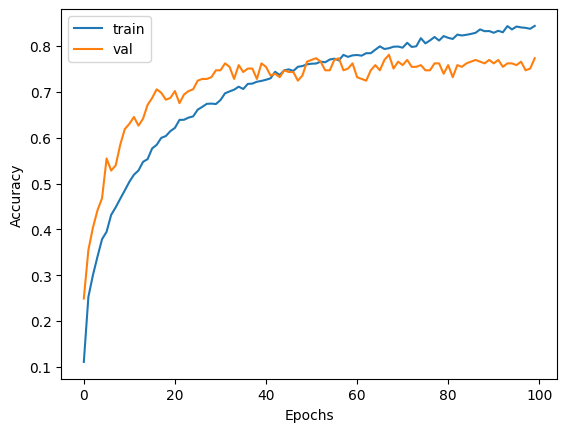

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('../Images/CNN Accuracy.png')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report: \n",classification_report(y_test,y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.83      1.00      0.91         5
           2       0.62      1.00      0.77         5
           3       0.83      1.00      0.91         5
           4       0.67      0.80      0.73         5
           5       0.83      1.00      0.91         5
           6       0.83      1.00      0.91         5
           7       0.71      1.00      0.83         5
           8       0.80      0.80      0.80         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       0.71      1.00      0.83         5
          12       0.75      0.60      0.67         5
          13       0.75      0.60      0.67         5
          14       0.57      0.80      0.67         5
          15       1.00      0.40      0.57         5
          16       1.00      0.60      0.75         5
  

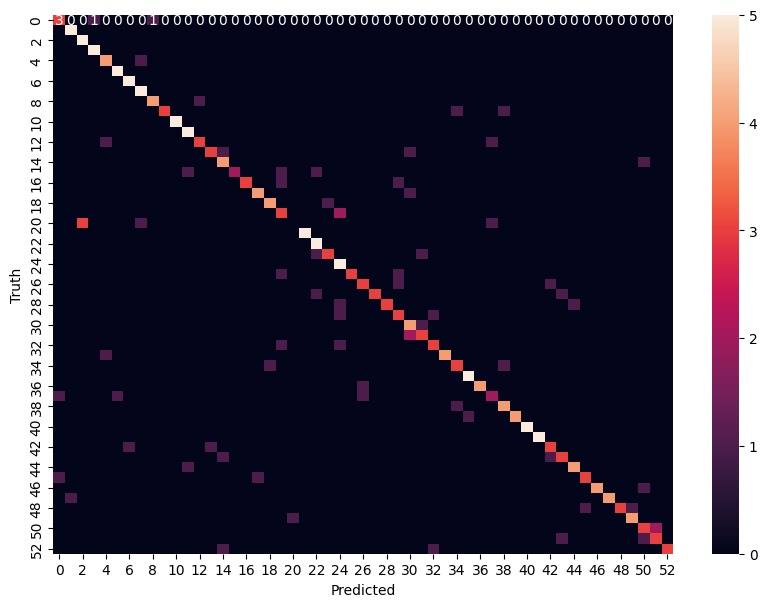

In [21]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_classes)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('../Images/CNN Confusion Matrix.png')

##  AlexNet Model

In [105]:
# Instantiate an empty sequential model
model = Sequential()
# 1st layer (conv + pool + batchnorm)
model.add(Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', input_shape = (128,128,3),activation='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(BatchNormalization())

# 2nd layer (conv + pool + batchnorm)
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model.add(BatchNormalization())

# layer 3 (conv + batchnorm)      <--- note that the authors did not add a POOL layer here
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())

# layer 4 (conv + batchnorm)     <--- similar to layer 4
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())

# layer 5 (conv + batchnorm) 
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))

# Flatten the CNN output to feed it with fully connected layers
model.add(Flatten())

# layer 6 (Dense layer + dropout) 
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))

# layer 7 (Dense layers)
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))

# layer 8 (softmax output layer)
model.add(Dense(units = 1000, activation = 'softmax'))

# print the model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 96)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 12, 12, 256)       0         
 ng2D)                                                           
                                                     

### Training

In [106]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD',metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100,validation_data=(X_val_scaled, y_val),verbose=2, shuffle=True,callbacks=[callbk])

Epoch 1/100
239/239 - 227s - loss: 4.5398 - accuracy: 0.0727 - val_loss: 3.4928 - val_accuracy: 0.1321 - 227s/epoch - 949ms/step
Epoch 2/100
239/239 - 225s - loss: 3.2658 - accuracy: 0.1768 - val_loss: 2.6966 - val_accuracy: 0.2189 - 225s/epoch - 942ms/step
Epoch 3/100
239/239 - 221s - loss: 2.8414 - accuracy: 0.2341 - val_loss: 2.7204 - val_accuracy: 0.2264 - 221s/epoch - 923ms/step
Epoch 4/100
239/239 - 229s - loss: 2.5996 - accuracy: 0.2832 - val_loss: 2.1430 - val_accuracy: 0.3660 - 229s/epoch - 958ms/step
Epoch 5/100
239/239 - 222s - loss: 2.4379 - accuracy: 0.3153 - val_loss: 1.9828 - val_accuracy: 0.4038 - 222s/epoch - 930ms/step
Epoch 6/100
239/239 - 221s - loss: 2.3144 - accuracy: 0.3368 - val_loss: 2.2400 - val_accuracy: 0.3434 - 221s/epoch - 926ms/step
Epoch 7/100
239/239 - 409s - loss: 2.2003 - accuracy: 0.3619 - val_loss: 2.1688 - val_accuracy: 0.4189 - 409s/epoch - 2s/step
Epoch 8/100
239/239 - 229s - loss: 2.0790 - accuracy: 0.4001 - val_loss: 3.2757 - val_accuracy: 0.16

Epoch 65/100
239/239 - 226s - loss: 0.0379 - accuracy: 0.9895 - val_loss: 1.1436 - val_accuracy: 0.7509 - 226s/epoch - 945ms/step
Epoch 66/100
239/239 - 220s - loss: 0.0321 - accuracy: 0.9907 - val_loss: 1.2548 - val_accuracy: 0.7396 - 220s/epoch - 921ms/step
Epoch 67/100
239/239 - 220s - loss: 0.0337 - accuracy: 0.9917 - val_loss: 1.1893 - val_accuracy: 0.7434 - 220s/epoch - 919ms/step
Epoch 68/100
239/239 - 218s - loss: 0.0401 - accuracy: 0.9895 - val_loss: 1.3939 - val_accuracy: 0.7472 - 218s/epoch - 911ms/step
Epoch 69/100
239/239 - 220s - loss: 0.0365 - accuracy: 0.9899 - val_loss: 1.2769 - val_accuracy: 0.7472 - 220s/epoch - 921ms/step
Epoch 70/100
239/239 - 219s - loss: 0.0297 - accuracy: 0.9928 - val_loss: 1.1227 - val_accuracy: 0.7585 - 219s/epoch - 915ms/step
Epoch 71/100
239/239 - 225s - loss: 0.0339 - accuracy: 0.9895 - val_loss: 1.2747 - val_accuracy: 0.7623 - 225s/epoch - 940ms/step
Epoch 72/100
239/239 - 1082s - loss: 0.0296 - accuracy: 0.9916 - val_loss: 1.2510 - val_ac

### Evaluation

In [107]:
y_pred = model.predict(X_test_scaled)
y_pred = tf.nn.softmax(y_pred)
y_classes = [np.argmax(element) for element in y_pred]
y_classes

9/9 [==============================] - 3s 258ms/step


[35,
 18,
 24,
 4,
 1,
 27,
 47,
 9,
 23,
 25,
 51,
 34,
 23,
 14,
 5,
 0,
 35,
 27,
 23,
 23,
 44,
 1,
 6,
 41,
 47,
 16,
 13,
 28,
 30,
 18,
 3,
 13,
 17,
 29,
 31,
 16,
 42,
 3,
 9,
 47,
 45,
 6,
 30,
 15,
 15,
 3,
 2,
 32,
 12,
 29,
 52,
 5,
 15,
 27,
 46,
 3,
 18,
 36,
 15,
 31,
 23,
 36,
 50,
 32,
 13,
 47,
 11,
 17,
 15,
 36,
 29,
 27,
 47,
 27,
 24,
 22,
 16,
 39,
 28,
 14,
 41,
 17,
 36,
 44,
 29,
 13,
 0,
 44,
 31,
 39,
 27,
 47,
 38,
 40,
 14,
 28,
 5,
 40,
 36,
 24,
 44,
 1,
 11,
 28,
 36,
 27,
 13,
 50,
 17,
 46,
 32,
 6,
 2,
 7,
 5,
 11,
 27,
 21,
 36,
 7,
 36,
 18,
 36,
 25,
 10,
 17,
 23,
 32,
 0,
 46,
 3,
 41,
 43,
 5,
 51,
 50,
 0,
 43,
 29,
 38,
 38,
 19,
 7,
 12,
 35,
 34,
 2,
 52,
 43,
 5,
 33,
 0,
 24,
 6,
 31,
 38,
 46,
 12,
 27,
 25,
 49,
 42,
 14,
 41,
 12,
 8,
 35,
 31,
 8,
 21,
 26,
 7,
 40,
 40,
 16,
 7,
 45,
 9,
 18,
 45,
 32,
 8,
 31,
 0,
 0,
 21,
 9,
 26,
 49,
 42,
 46,
 13,
 29,
 21,
 6,
 19,
 1,
 34,
 39,
 16,
 22,
 23,
 16,
 48,
 49,
 17,
 1,
 2,
 11,


In [108]:
test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
test_acc

[1.7509592771530151, 0.7094339728355408]

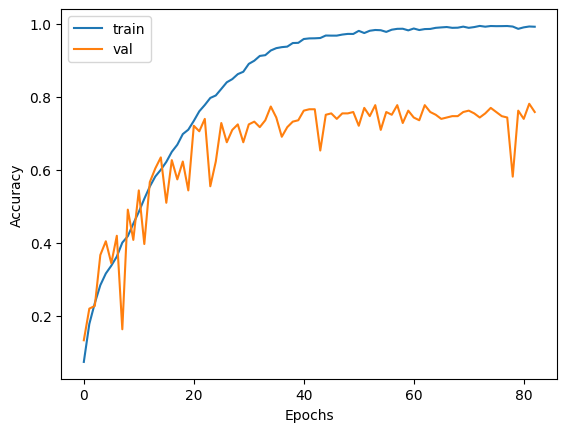

In [113]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('../Images/AlexNet Accuracy.png')
plt.show()

In [110]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report: \n",classification_report(y_test,y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       0.75      0.60      0.67         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       0.57      0.80      0.67         5
           8       1.00      0.60      0.75         5
           9       0.80      0.80      0.80         5
          10       1.00      0.80      0.89         5
          11       0.80      0.80      0.80         5
          12       0.80      0.80      0.80         5
          13       0.83      1.00      0.91         5
          14       0.83      1.00      0.91         5
          15       0.60      0.60      0.60         5
          16       0.67      0.80      0.73         5
  

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


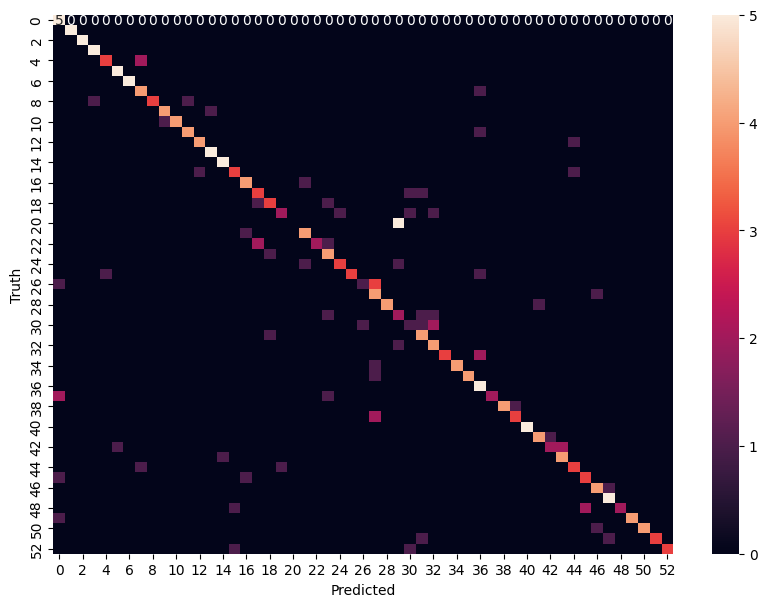

In [112]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_classes)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('../Images/AlexNet Confusion Matrix.png')

## EfficientNetB Model

In [18]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [19]:
# Prepare DataLoader
def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [20]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((128, 128)),  # Ensure the size matches the model input
    transforms.ToTensor(),  # Convert to tensor and normalize to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Apply transformations to your dataset
def apply_transformations(X, y):
    transformed_images = []
    for img in X:
        img = transform(img)  # Apply transformations
        transformed_images.append(img)
    return torch.stack(transformed_images), torch.tensor(y, dtype=torch.long)

# Apply transformations to your datasets
X_train_transformed, y_train = apply_transformations(X_train_scaled, y_train)
X_val_transformed, y_val = apply_transformations(X_val_scaled, y_val)
X_test_transformed, y_test = apply_transformations(X_test_scaled, y_test)

train_loader = create_dataloader(X_train_transformed, y_train)
val_loader = create_dataloader(X_val_transformed, y_val)
test_loader = create_dataloader(X_test_transformed, y_test, shuffle=False)

### Training

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses, val_losses = [], []

In [22]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")


Validation loop: 100%|████████████████████████████| 9/9 [00:14<00:00,  1.62s/it]


Epoch 1/5 - Train loss: 1.6412, Validation loss: 0.4468


Validation loop: 100%|████████████████████████████| 9/9 [00:14<00:00,  1.56s/it]


Epoch 2/5 - Train loss: 0.5777, Validation loss: 0.3336


Validation loop: 100%|████████████████████████████| 9/9 [00:14<00:00,  1.58s/it]


Epoch 3/5 - Train loss: 0.3618, Validation loss: 0.0939


Validation loop: 100%|████████████████████████████| 9/9 [00:14<00:00,  1.58s/it]


Epoch 4/5 - Train loss: 0.2360, Validation loss: 0.1960


Validation loop: 100%|████████████████████████████| 9/9 [00:14<00:00,  1.56s/it]

Epoch 5/5 - Train loss: 0.1920, Validation loss: 0.1589


### Evaluation

In [23]:
# Accuracy on the test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing loop'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Testing loop: 100%|███████████████████████████████| 9/9 [00:14<00:00,  1.56s/it]

Test Accuracy: 0.9509


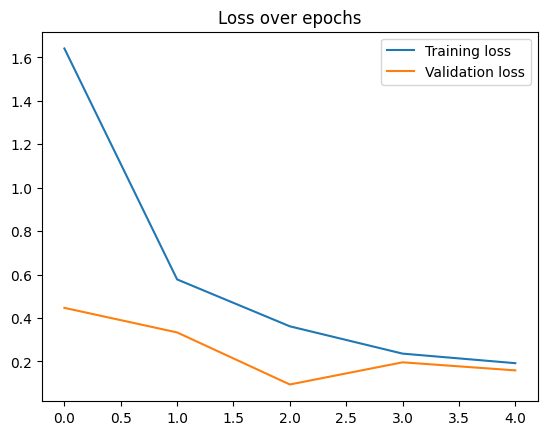

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.savefig('../Images/EfficientNetB Loss.png')
plt.show()